# Basics of reading an MRC file with 4D STEM data from the Spectra300 at UTK
## By Austin Houston
### Last updated 2024-09-03

In [5]:
import os
import sys

%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, '/Users/austin/Documents/GitHub/SciFiReaders/')
import SciFiReaders
print("SciFiReaders version: ", SciFiReaders.__version__)

sys.path.insert(0,'/Users/austin/Documents/GitHub/pyTEMlib/')
import pyTEMlib
import pyTEMlib.file_tools as ft

print("pyTEMlib version: ", pyTEMlib.__version__)


# for beginning analysis
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import center_of_mass


SciFiReaders version:  0.11.6
pyTEMlib version:  0.2024.09.14


In [6]:
mrc_filepath = '/Users/austin/Dropbox/GaTech_colabs/ScFeO3_Al2O3/2024_07_03/4D_stem/'

files = os.listdir(mrc_filepath)
files = [f for f in files if f.endswith('.mrc')]


# Load the first file
dset = ft.open_file(mrc_filepath + files[1])

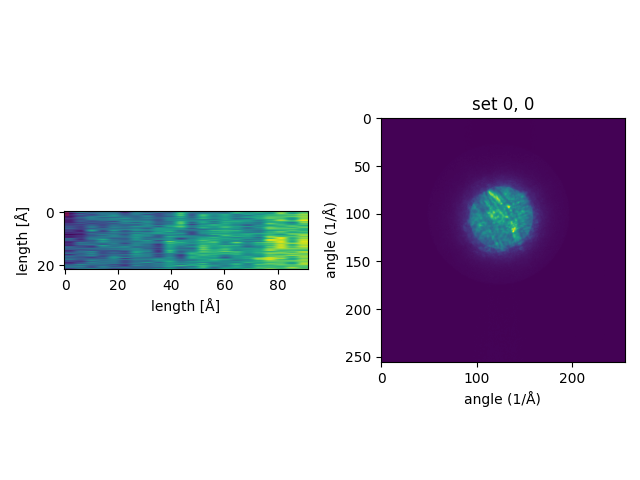

In [9]:
data = dset['Channel_000']

view = data.plot()

In [15]:
mrc_array = np.array(data)
N, M, height, width = data.shape
datacube_flat = mrc_array.reshape(N * M, -1)

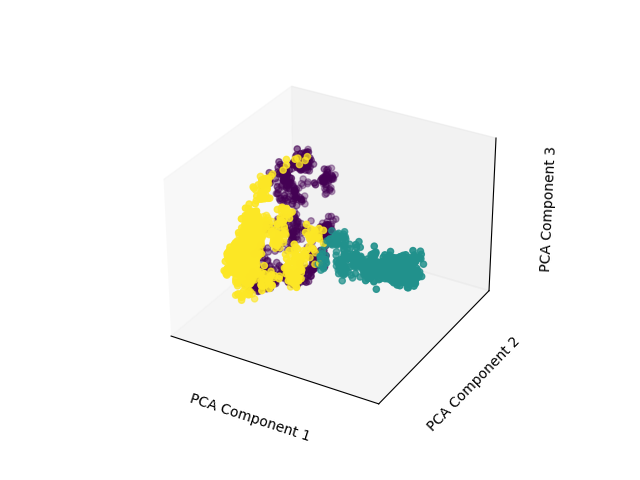

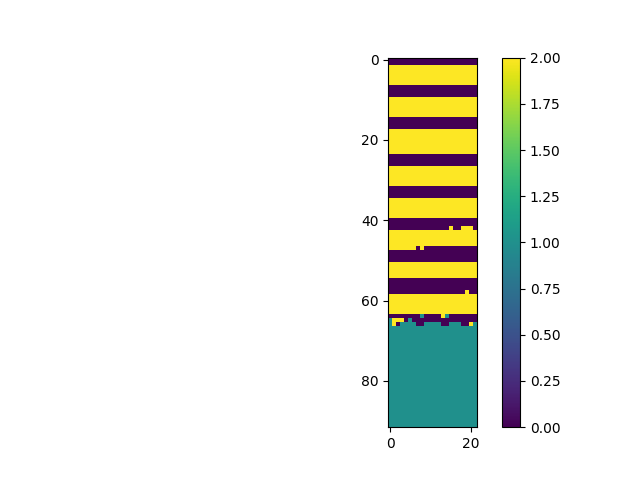

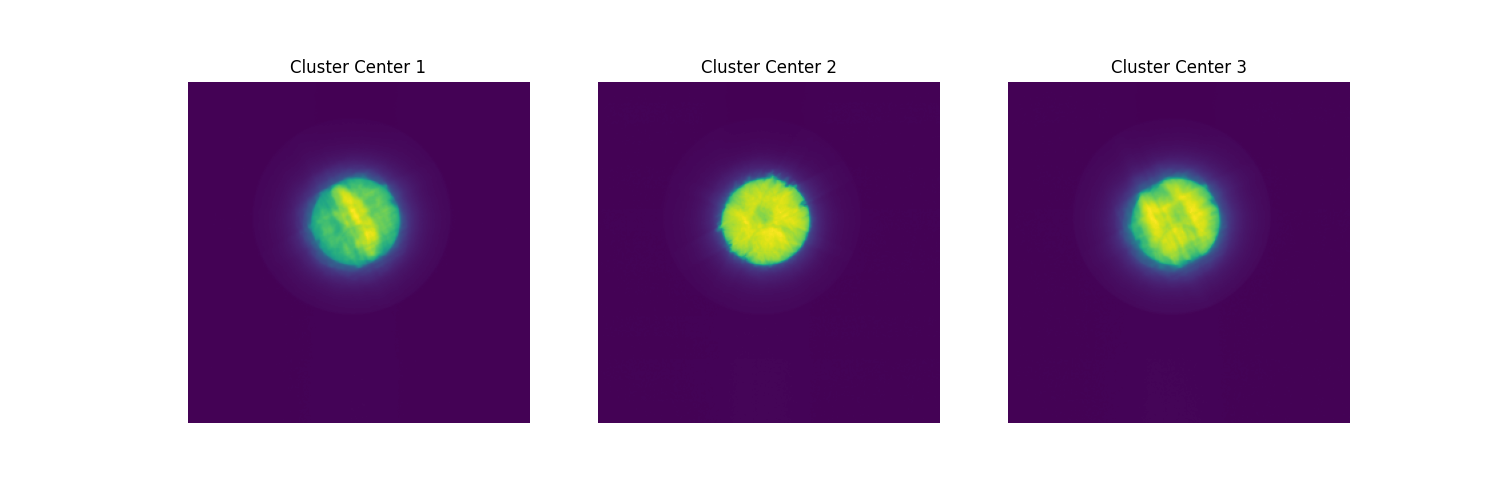

In [16]:
# Perform KMeans clustering
clusters = 3 
kmeans = KMeans(n_clusters=clusters, random_state=0).fit(datacube_flat)
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

# Reduce the data to 3D using PCA
pca = PCA(n_components=3)
datacube_reduced = pca.fit_transform(datacube_flat)
cluster_centers_reduced = pca.transform(cluster_centers)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(datacube_reduced[:, 0], datacube_reduced[:, 1], datacube_reduced[:, 2], c=labels, cmap='viridis', marker='o')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.show()


label_image = labels.reshape((M, N))

plt.figure()
plt.imshow(label_image, cmap='viridis')
plt.colorbar()
plt.show()

# Reshape cluster centers back to original image dimensions
cluster_center_images = cluster_centers.reshape((kmeans.n_clusters, height, width))

# Plot the average images
fig, axes = plt.subplots(1, kmeans.n_clusters, figsize=(15, 5))

for i, ax in enumerate(axes):
    ax.imshow(cluster_center_images[i], cmap='viridis')
    ax.set_title(f'Cluster Center {i+1}')
    ax.axis('off')

plt.show()